In [1]:
import torch,gensim,pandas as pd, numpy as np, math, tikzplotlib
from nltk.tokenize import sent_tokenize, word_tokenize
from tqdm import tqdm_notebook as tqdm

from src.factsoranalysis import FactsOrAnalysis
from src.dataset import tensorFromSentence, Lexicon
from src.util import get_the_best_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
embeddings_file="../frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin"
embeddings = gensim.models.KeyedVectors.load_word2vec_format(embeddings_file,binary=True,unicode_errors='ignore')
embeddings_tensor = torch.FloatTensor(embeddings.vectors)
model=FactsOrAnalysis(embeddings_tensor).to(device)
lexicon=Lexicon(embeddings)
model.load_state_dict(torch.load("../facts_or_analysis.pt"))

In [3]:
# df = pd.read_csv('../datasets/output_post_clf_dataset_v2.tsv',sep='\t')

# f_a = []
# for row in tqdm(df.iterrows(),desc="reading data..."):
#     if type(row[1].loc['Facts']) == str:
#         f_a.append((row[1].loc['Facts'],row[1].loc['Analysis']))
        
# f_a=[doc for doc in f_a if type(doc[1])!=float]

In [4]:
df_10k=pd.read_csv('../datasets/dataset_10k.csv')
f_a_10k=[]

for row in tqdm(df_10k.iterrows(),desc="reading data..."):
    if type(row[1].loc['Facts']) == str:
        f_a_10k.append((row[1].loc['Facts'],row[1].loc['Analyses']))

/home/andres/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
f_a_10k=[[doc[0].replace("-","."), doc[1].replace("-",".")] for doc in f_a_10k]
f_a_10k=[[doc[0].replace("\n"," "), doc[1].replace("\n"," ")] for doc in f_a_10k]

In [6]:
f_a_sample = f_a_10k[:100]
best_indices=[]
sequences=[]
for i, doc in enumerate(tqdm(f_a_sample,desc="Getting best indices and sequences")):
    sentences = doc[0]+doc[1]
    sentences_ = sentences = sent_tokenize(sentences,language='french')
    sentences = [sentence for sentence in sentences if len(sentence.split()) > 2 and len(sentence.split()) <= 50]
#     for index,sentence in enumerate(sentences): print(index,sentence)
    tensors = [tensorFromSentence(lexicon,sentence) for sentence in sentences]
    tensors = [tensor.to(device) for tensor in tensors]
#     for index,tensor in enumerate(tensors): print(index,tensor.shape)
    sequence = [model(tensor.view(1,-1)) for tensor in tensors]
    sequence = [tensor.squeeze()[0].item() for tensor in sequence]
    sequence = [round(item) for item in sequence]
    best_index = get_the_best_split(sequence)
    best_indices.append(best_index)
    sequences.append(sequence)

In [7]:
f = tqdm([fa[0] for fa in f_a_sample],desc="Retrieving target facts...",leave=False)
l = np.array([len(word_tokenize(doc)) for doc in f])

In [8]:
mean_stdev=[]

gamma=0.5
gamma_iter=tqdm([.5,.6,.7,.75,.8,.9,1,],desc="gamma: {}".format(gamma),leave=True)
for gamma in gamma_iter:
    gamma_iter.set_description("gamma: {}".format(gamma))
    fa_pred = []
    avg_purity=[]
    avg_nfacts=[]
    for i, doc in enumerate(tqdm(f_a_sample,desc="Slicing paragraphs...",leave=False)):
        sentences = doc[0]+doc[1]
        sentences = sent_tokenize(sentences,language='french')
        index=math.floor(best_indices[i]*gamma)
        fa_pred.append(sentences[:index+1])
        purity=sequences[i][:index]
        avg_nfacts.append(sum(purity))
        try:
            purity=sum(purity)/index
        except ZeroDivisionError:
            purity=1
        avg_purity.append(purity)
        
    print("avg purity: {:.2f}".format(sum(avg_purity)/len(avg_purity)))
    print("avg nb facts: {:.2f}".format(sum(avg_nfacts)/len(avg_purity)))
        
    f_pred = tqdm([" ".join(sentence) for sentence in fa_pred],desc="Joining sentences...",leave=False)
    l_pred = np.array([len(word_tokenize(doc)) for doc in f_pred])
    mean_stdev.append([gamma,np.mean(l_pred/l),np.std(l_pred/l)])
    gamma_iter.refresh()
#     print("avg:",np.mean(l_pred/l))
#     print("st_dev:",np.std(l_pred/l))
        

avg purity: 0.78
avg nb facts: 17.45


avg purity: 0.77
avg nb facts: 20.09


avg purity: 0.74
avg nb facts: 22.55


avg purity: 0.73
avg nb facts: 23.55


avg purity: 0.72
avg nb facts: 24.51


avg purity: 0.71
avg nb facts: 26.72


avg purity: 0.68
avg nb facts: 29.06


In [9]:
import matplotlib.pyplot as plt

m = np.array(mean_stdev)

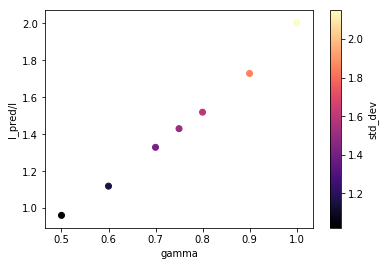

In [10]:
plt.scatter(m[:,0], m[:,1],c=m[:,2],cmap='magma')
plt.xlabel("gamma")
plt.ylabel("l_pred/l")
plt.colorbar().set_label("std_dev")
plt.show()

In [11]:
m = np.array([])